# 2D Air Temperature Analysis: Baseline vs. Scenario

This notebook provides a comprehensive analysis of 2-meter air temperature (`ta_2m`) from PALM (Potsdam Atmospheric Large-Eddy Simulation Model) 2D output files. It compares a Baseline simulation scenario against a modified Scenario 1, focusing on:
-   **Data Loading and Preprocessing:** Importing 2D `av_xy_N03.000.nc` files and static driver data.
-   **Variable Selection:** Allowing interactive selection of the 2D variable for analysis.
-   **Time Series Analysis:** Defining time sequences and equivalents for temporal aggregation and plotting.
-   **Statistical Comparison:** Performing independent t-tests between the two simulation scenarios across various Areas of Interest (AOIs) and buffer distances.
-   **Visualization:** Generating line plots to show temperature trends over time for different AOIs and a bar graph to summarize t-test results.
-   **Data Summarization:** Presenting key statistics (min/max temperatures) for both scenarios and t-test outcomes.

The goal is to assess the impact of changes introduced in Scenario 1 on air temperature by comparing it against the Baseline, quantifying statistical differences, and visualizing trends.

## 1. Import dependencies

This section imports all necessary libraries for data manipulation, NetCDF file handling, geographical data processing, statistical analysis, interactive widgets, and advanced plotting capabilities.

In [45]:
import os

import numpy as np
import netCDF4 as nc

import geopandas as gpd
import pandas as pd
from scipy import stats

from IPython.display import display
import ipywidgets as widgets

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
from matplotlib.ticker import FixedLocator, MultipleLocator # Ensure MultipleLocator is imported here
from matplotlib.patches import Patch

from utils import palm_variables

## 2. Import data
This section defines the file paths for the 2D simulation output NetCDF files (for baseline and scenario 1) and the static driver file. These files are then loaded into netCDF4 Dataset objects, making their contents accessible for processing. The buildings_2d data from the static driver is also extracted, which is used for masking non-atmospheric grid cells during data extraction.

In [46]:
# Absolute URLs (paths) of 2D xy-averaged simulation output files and the static driver file.
file_xy_1 = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Baseline-48hr/OUTPUT/konstanz_4096x4096_v9_Baseline_av_xy_N03.000.nc"
file_xy_2 = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Scenario_1-48hr/OUTPUT/konstanz_4096x4096_v9_Scenario_1_av_xy_N03.000.nc"
file_static = r"./Data/_simulation_outputs_3/konstanz_4096x4096_v9_Scenario_1-48hr/INPUT/konstanz_4096x4096_v9_Scenario_1_static_N03"

# Read NetCDF files into Dataset objects in read mode ('r').
dataset_1 = nc.Dataset(file_xy_1, mode='r')
dataset_2 = nc.Dataset(file_xy_2, mode='r')
dataset_3 = nc.Dataset(file_static, mode='r')

# Store the Dataset objects and their corresponding file paths in lists for easy iteration.
file_xy_list = [file_xy_1, file_xy_2]
dataset_list = [dataset_1, dataset_2]

# Extract 2D buildings data from the static dataset.
# This data is crucial for masking out non-atmospheric grid cells (e.g., inside buildings)
# when performing spatial averages or statistical tests.
buildings_2d = dataset_3['buildings_2d']
buildings_2d_data = buildings_2d[:, :]

## 3. Variable Selection
This section allows the user to interactively select a 2D variable from the loaded NetCDF datasets. A dropdown widget is provided for selection, and the chosen variable's description and unit (retrieved from the palm_variables module) are displayed for clear identification.

In [47]:
# Extract variable names from the first dataset where the number of dimensions is greater than 2.
# In PALM xy-averaged output files, these typically represent 2D spatial data over time (time, y, x).
var_names_palm = [var for var in dataset_1.variables if dataset_1.variables[var].ndim > 2]

# Initialize `test_variable` with the first variable in the list (`var_names_palm[0]`),
# which is commonly 'ta_2m*_xy' for 2-m air temperature.
test_variable = var_names_palm[0]

# Create a dropdown widget to allow the user to select the desired 2D variable.
drop_down = widgets.Dropdown(
    options=var_names_palm,         # Populate the dropdown with the extracted 2D variable names.
    value=var_names_palm[0],        # Set the initial selected value in the dropdown.
    description='Select test variable:' # Label displayed next to the dropdown.
)

# Define a handler function that will be called whenever the dropdown's value changes.
def dropdown_handler(change):
    global test_variable  # Declare `test_variable` as global to modify it.
    test_variable = change.new     # Update the global `test_variable` with the newly selected value.
    print(f"Selected variable: {test_variable}") # Print the newly selected variable to the console.

# Attach the `dropdown_handler` function to observe changes in the 'value' property of the dropdown.
drop_down.observe(dropdown_handler, names='value')

# Display the dropdown widget in the notebook output.
display(drop_down)

Dropdown(description='Select test variable:', options=('ta_2m*_xy', 'tsurf*_xy', 'wspeed_10m*_xy', 'bio_pet*_x…

In [48]:
# Check if the selected `test_variable` string contains a wildcard character '*'.
# This is common for PALM variables indicating an xy-averaged or general 2D field.
if "*" in test_variable:
    # If a wildcard is present, extract the base part of the variable name (e.g., 'ta_2m' from 'ta_2m*_xy')
    # and re-append '*' to match the keys in `palm_variables.variables_dict`.
    var_initial = test_variable.split("*")[0] + "*"
    # Retrieve the dictionary of information for `var_initial` from the `palm_variables` module.
    variable_info = palm_variables.variables_dict.get(var_initial, {})
    # Extract the 'unit' from `variable_info`, defaulting to 'No unit available' if the key is missing.
    unit = variable_info.get('unit', 'No unit available')
    # Extract the 'description' from `variable_info`, defaulting to 'No description available' if the key is missing.
    description = variable_info.get('description', 'No description available')
    # Print the capitalized description and its unit.
    print(f"{description.capitalize()}, {unit}")

2-m air temperature, °C


## 4. Define Time Sequences and Equivalents
This section dynamically extracts the total number of time steps from the loaded dataset. It then defines parameters for time step intervals and calculates sequences and human-readable time equivalents (HH:MM format) for both hourly and all time steps. These sequences are crucial for temporal aggregation and plotting.

In [49]:
# Extract `variable_data_1` for the `test_variable` from the first dataset.
variable_data_1 = dataset_1[test_variable]

# Get the shape of `variable_data_1` to determine the total number of time steps.
variable_data_shape = np.shape(variable_data_1)
total_time_steps = variable_data_shape[0] # The first dimension is usually time.

# Display the total number of time steps.
total_time_steps

288

In [50]:
# Define `time_step_interval`: This controls how frequently data points are sampled or aggregated.
# In PALM, each time step typically represents 10 minutes.
#   - `time_step_interval = 1`: Corresponds to every 10-minute interval.
#   - `time_step_interval = 6`: Corresponds to hourly intervals (6 * 10 minutes = 60 minutes).
time_step_interval = 6

# Define `second_step`: This offset helps align `time_sequence_hourly` with actual hour marks.
# If time steps are 0-indexed and represent 10-minute intervals:
#   - `second_step = 0`: Corresponds to 0:00, 0:10, 0:20...
#   - `second_step = 5`: Corresponds to 0:50, 1:50, 2:50... (often used for hourly averages centered at the hour)
second_step = 5

# `time_sequence_hourly`: A list of time step indices for hourly intervals.
# It starts at `0` and extends by `time_step_interval` from `second_step`.
time_sequence_hourly = [0]
time_sequence_hourly.extend(np.arange(second_step, total_time_steps, time_step_interval))

# `time_sequence_all`: A list containing all available time step indices (from 0 to `total_time_steps - 1`).
time_sequence_all = range(total_time_steps)

def get_time_equivalent(time_sequence):
    """
    Converts a sequence of time steps (each representing 10 minutes) into
    human-readable HH:MM format.

    Args:
        time_sequence (list or array): A list of time step indices.

    Returns:
        tuple: A tuple containing:
            - time_equivalent (list): List of time strings in HH:MM format (can exceed 24 hours).
            - time_equivalent_24hr (list): List of time strings in 24-hour HH:MM format (resets after 23:50).
    """
    time_equivalent = []
    time_equivalent_24hr = []
    
    for time_step in time_sequence:
        # Calculate total minutes from the start of the simulation (each step is 10 minutes).
        total_minutes = (time_step + 1) * 10 
        hours, minutes = divmod(total_minutes, 60) # Convert total minutes to hours and remaining minutes.
        
        # Append time equivalent in HH:MM format (hours can exceed 24, e.g., 25:00 for the next day).
        time_equivalent.append(f"{hours:02d}:{minutes:02d}")
        
        # Calculate hours in a 24-hour cycle for `time_equivalent_24hr`.
        hours_24hr = hours % 24 
        time_equivalent_24hr.append(f"{hours_24hr:02d}:{minutes:02d}")
    
    return time_equivalent, time_equivalent_24hr

# Generate time equivalents for hourly and all time steps.
time_equivalent_hourly, time_equivalent_hourly_24hr = get_time_equivalent(time_sequence_hourly)
time_equivalent_all, time_equivalent_all_24hr = get_time_equivalent(time_sequence_all)

## 5. Helper Functions for Spatial Operations and Plotting
This section defines several helper functions crucial for spatial data manipulation and plot customization. These include functions for calculating grid coordinates, adjusting plot ticks, determining the date based on time index, and adding north arrows and scale bars to plots.

In [51]:
# Define grid spacing (dx, dy) from the first dataset.
# Assuming dx and dy are constant and can be derived from the first two x/y coordinates.
dx = dataset_1['x'][1] - dataset_1['x'][0]
dy = dataset_1['y'][1] - dataset_1['y'][0]

# Define number of cells in x and y dimensions.
# These are derived from the length of the 'x' and 'y' dimensions in the dataset.
nx = np.shape(dataset_1['x'])[0]
ny = np.shape(dataset_1['y'])[0]

# Coordinates of the origin in PALM (origin_x, origin_y, origin_z).
# These represent the real-world (e.g., UTM) coordinates of the southwest corner of the simulation domain.
origin_x, origin_y, origin_z = dataset_1.origin_x, dataset_1.origin_y, dataset_1.origin_z

# Vectors for coordinate at cell edges (x, y).
# These arrays define the real-world coordinates of the grid cell boundaries.
x = np.arange(nx + 1) * dx + origin_x
y = np.arange(ny + 1) * dy + origin_y

# Vectors for coordinates at cell centers (xc, yc).
# These arrays define the real-world coordinates of the center of each grid cell.
xc = np.arange(nx) * dx + origin_x + dx / 2
yc = np.arange(ny) * dy + origin_y + dy / 2

# `origin_time`: The base time for the simulation, typically a string.
origin_time = dataset_1.origin_time
# `time_step`: The time interval between consecutive simulation output steps, in seconds.
time_step = 600  # Default PALM output time step (10 minutes).
# `nt`: Total number of time steps in the dataset.
nt = np.shape(dataset_1['time'])[0]

In [52]:
def center_yticks(ax):
    """
    Adjusts the vertical alignment of y-axis tick labels to be centered.

    Args:
        ax (matplotlib.axes.Axes): The axes object of the plot.
    """
    # Get the current y-tick positions and generate corresponding labels.
    tick_positions = ax.get_yticks()
    tick_labels = [f'{pos:.2f}' for pos in tick_positions] # Format to two decimal places.
    
    # Set the tick positions explicitly using `FixedLocator` to prevent Matplotlib from auto-adjusting.
    ax.yaxis.set_major_locator(FixedLocator(tick_positions))
    
    # Set the y-tick labels with centered vertical alignment, and specify rotation and font size.
    ax.set_yticklabels(tick_labels, rotation=90, verticalalignment='center', fontsize=12)

In [53]:
def get_date_day(time_index):
    """
    Determines the simulation day (14 or 15) based on the time index,
    assuming 10-minute time steps where 144 steps represent 24 hours.

    Args:
        time_index (int): The time step index (0-indexed).

    Returns:
        int: The day number (14 for the first 24 hours, 15 for the next).
    """
    # 144 time steps = 144 * 10 minutes = 1440 minutes = 24 hours.
    if time_index < 144:
        return 14 # First day (June 14th)
    else:
        return 15 # Second day (June 15th)

In [54]:
def get_extents(gdf_combined, location_id, increased_distance):
    """
    Calculates the array indices (extents) for a given geographical polygon (AOI)
    with an optional buffer distance.

    Args:
        gdf_combined (geopandas.GeoDataFrame): GeoDataFrame containing all AOI polygons.
        location_id (int): Index of the specific AOI in gdf_combined.
        increased_distance (int): The buffer distance in grid cells to expand the AOI.

    Returns:
        tuple: A tuple (x_low, y_low, x_high, y_high) representing the array indices
               of the bounding box for the buffered AOI, clamped to the simulation domain boundaries.
    """
    # Extract the polygon geometry for the given location ID.
    polygon_aug = gdf_combined.iloc[location_id]
    polygon = polygon_aug.geometry
    min_x, min_y, max_x, max_y = polygon.bounds

    # Convert geographic coordinates to array indices (assuming dx = dy).
    x1 = int((min_x - origin_x) / dx)
    y1 = int((min_y - origin_y) / dy)
    x2 = int((max_x - origin_x) / dx)
    y2 = int((max_y - origin_y) / dy)

    # Calculate half-window for the increased distance.
    half_window = int(increased_distance / 2)

    # Apply the buffer to the extents.
    x_low, x_high = x1 - half_window, x2 + half_window
    y_low, y_high = y1 - half_window, y2 + half_window

    # Clamp the extents to the simulation domain boundaries (0 to nx/ny).
    # Ensures that the extracted region does not go out of bounds of the simulation grid.
    x_low = max(0, x_low)
    y_low = max(0, y_low)
    x_high = min(nx, x_high) # Use nx for x_high boundary.
    y_high = min(ny, y_high) # Use ny for y_high boundary.

    return (x_low, y_low, x_high, y_high)

In [55]:
def plot_north_arrow_and_scale_bar():
    """
    Adds a north arrow and a customizable scale bar to the current matplotlib axes.
    The positions are hardcoded for the specific simulation domain of Konstanz.
    """
    # Hardcoded top-right coordinates for the north arrow position (adjust as needed for different plots/domains).
    top_right_x = 513390
    top_right_y = 5278890
    
    # Create the north arrow as a FancyArrowPatch.
    arrow = patches.FancyArrowPatch((top_right_x, top_right_y - 40), (top_right_x, top_right_y),
                                    arrowstyle='simple', linewidth=1.5, mutation_scale=25, color='k')
    # Add 'N' text near the arrow.
    ax.text(top_right_x, top_right_y - 50, 'N', fontsize=20, color='k', ha='center', va='center', weight='bold')
    ax.add_patch(arrow)    

    # Hardcoded bottom-right coordinates for the scale bar position.
    scale_bar_x = 513250
    scale_bar_y = 5278410
    
    scale_bar_length_meters = 150  # Total length of the scale bar.
    scale_bar_segment_length = 50  # Length of each alternating black/white segment.
    
    # Create the scale bar as a collection of alternating segments.
    num_segments = int(scale_bar_length_meters / scale_bar_segment_length)
    num_labels = num_segments + 1 # Number of labels (0m, 50m, 100m, 150m).
    segment_width = scale_bar_length_meters / num_segments # Width of each segment.
    
    for i in range(num_segments):
        # Alternate colors for segments.
        if i % 2 == 0:
            segment_color = 'k'  # Black for even segments.
        else:
            segment_color = 'w'  # White for odd segments.
        
        segment_x = scale_bar_x + i * segment_width # X-coordinate for the start of the segment.
        # Create a rectangle patch for each segment.
        scale_bar_segment = patches.Rectangle((segment_x, scale_bar_y), segment_width, 15, linewidth=1, edgecolor='w', facecolor=segment_color)
        ax.add_patch(scale_bar_segment)
    
    # Add labels (0m, 50m, 100m, etc.) to the scale bar.
    for i in range(num_labels):
        scale_bar_label = f'{i*scale_bar_segment_length}m' # Label text.
        text_x = scale_bar_x + scale_bar_segment_length * i # X-coordinate for label.
        text_y = scale_bar_y + 25 # Y-coordinate for label (slightly above the bar).
        
        # Add text label with a white background bbox for visibility.
        ax.text(text_x, text_y, scale_bar_label, fontsize=10, ha='center', color='k', weight='bold',
                bbox=dict(facecolor='white', edgecolor='white', boxstyle='round, pad=0.1'))

## 6. Extract Variable Data and Define Areas of Interest (AOIs)
This section loads the selected variable data from both simulation scenarios and reads shapefiles defining specific Areas of Interest (AOIs). These AOIs will be used to extract relevant data subsets for statistical analysis and comparison. Predefined lists for scenario names and AOI labels are also set up.

In [56]:
# Load `variable_data_1` and `variable_data_2` for the `test_variable` from the respective datasets.
variable_data_1 = dataset_1[test_variable]
variable_data_2 = dataset_2[test_variable]
# Store them in a list for easy iteration.
variable_datas = [variable_data_1, variable_data_2]

# Define names for the simulation scenarios, to be used in labels and legends.
sim_scenarions = ['Baseline (BS)', 'Scenario 1 (S1)']
sim_scene = ['BS', 'S1']

# Define paths to shapefiles containing AOI definitions.
# `shapefile_path_child_ii`: For "Child II" AOIs.
shapefile_path_child_ii = r"./Data/shapefiles/03_AOI_Child_II.shp"
# `shapefile_path_uhi_study`: For Urban Heat Island (UHI) study AOIs.
shapefile_path_uhi_study = r"./Data/shapefiles/UHI_aoi_study_fitted.shp"

# Read the shapefiles into GeoDataFrames.
gdf_child = gpd.read_file(shapefile_path_child_ii)
gdf_uhi = gpd.read_file(shapefile_path_uhi_study)

# Combine the GeoDataFrames into a single GeoDataFrame for unified indexing of all AOIs.
gdf_combined = gpd.pd.concat([gdf_child, gdf_uhi], ignore_index=True)

# Define lists of location names and AOI names, corresponding to the combined GeoDataFrame.
# These will be used for labeling plots and tables.
location_name_list = ['Overall', 'Stephansplatz', 'Markstaette', 'Augustinerplatz']
aoi_name_list = ['Overall', 'AOI1', 'AOI2', 'AOI3']

## 7. Define Aggregation Logic
This section defines the get_aggregate_time_list function, which creates lists of time steps for temporal aggregation. This function is designed to generate moving windows of time steps, enabling the calculation of aggregated values (e.g., averages) over specified durations, which can then be used in statistical analyses.

In [57]:
def get_aggregate_time_list(total_time_steps, aggregate_time_steps):
    """
    Generates a list of time step ranges for temporal aggregation, creating a moving window.

    Args:
        total_time_steps (int): Total number of time steps in the simulation.
        aggregate_time_steps (int): The size of the aggregation window (number of time steps).

    Returns:
        list: A list where each element is a sub-list of time step indices
              representing an aggregation window.
    """
    time_lists = []
    
    for i in range(total_time_steps):
        if aggregate_time_steps <= 1:
            time_list = [i] # No aggregation: window is just the current time step.
        else:
            half_window = aggregate_time_steps // 2 # Calculate half-window size.
            
            # Determine the start and end indices of the window based on even/odd `aggregate_time_steps`.
            if aggregate_time_steps % 2 == 0:
                # For even window, it's centered such that `i` is towards the end of the first half.
                # Example: for aggregate_time_steps=6, half_window=3. For `i=10`, range is [7, 13) -> [7, 8, 9, 10, 11, 12].
                time_list = [j for j in range(i - half_window, i + half_window)]
            else:
                # For odd window, it's perfectly centered around `i`.
                # Example: for aggregate_time_steps=5, half_window=2. For `i=10`, range is [8, 13) -> [8, 9, 10, 11, 12].
                time_list = [j for j in range(i - half_window, i + half_window + 1)]
        
        # Filter out time indices that are outside the total simulation time steps.
        valid_time_list = [j for j in time_list if 0 <= j < total_time_steps]
        time_lists.append(valid_time_list)
    
    return time_lists

In [58]:
# Initialize global variables to store the overall maximum and minimum values.
# `value_maximum` is set to 0, `value_minimum` is set to a very large number to ensure any real value updates it.
global value_maximum, value_minimum
value_maximum = 0
value_minimum = 999999

# Iterate through all available time steps.
for time_index_test in time_sequence_all:
    # Extract data for the current time step from `variable_data_1` (Baseline).
    # Assuming `variable_data_1` has dimensions (time, z, y, x) or (time, y, x).
    # If 4D, `[time_index_test, 0, :, :]` extracts the 2D slice at z=0. If 3D, `[time_index_test, :, :]`.
    value_test_1 = variable_data_1[time_index_test, 0, :, :] 
    # Apply the 2D building mask to exclude values within buildings.
    value_test_1.mask = ~buildings_2d_data.mask

    # Extract data for the current time step from `variable_data_2` (Scenario 1).
    value_test_2 = variable_data_2[time_index_test, 0, :, :]
    value_test_2.mask = ~buildings_2d_data.mask

    # Find the maximum and minimum non-masked values for the current time step across both scenarios.
    max_value_test = max(np.nanmax(value_test_1), np.nanmax(value_test_2))
    min_value_test = min(np.nanmin(value_test_1), np.nanmin(value_test_2))

    # Update the global `value_maximum` if the current `max_value_test` is greater.
    if value_maximum <= max_value_test:
        value_maximum = max_value_test
    # Update the global `value_minimum` if the current `min_value_test` is smaller.
    if value_minimum >= min_value_test:
        value_minimum = min_value_test

# Print the final global maximum and minimum values found.
print(f"Overall Maximum Temperature: {value_maximum:.2f}")
print(f"Overall Minimum Temperature: {value_minimum:.2f}")

Overall Maximum Temperature: 35.47
Overall Minimum Temperature: 13.54


## 8. Perform Statistical Analysis and Create DataFrames
This section defines create_aggregated_dataframe, a key function that extracts variable data for specified AOIs and buffer distances, computes mean and median values, and performs independent t-tests between the two simulation scenarios (variable_data_1 and variable_data_2). It then organizes these results into a pandas DataFrame.

In [59]:
def create_aggregated_dataframe(loc_id, inc_dist, time_lists):
    """
    Extracts variable data for a specified Area of Interest (AOI) and buffer distance,
    computes mean and median values, and performs independent t-tests between two
    simulation scenarios. Results are returned in a pandas DataFrame.

    Args:
        loc_id (int): The index of the AOI in `gdf_combined`.
        inc_dist (int): The increased buffer distance (in grid cells) around the AOI.
        time_lists (list): A list of time step ranges for temporal aggregation.

    Returns:
        pandas.DataFrame: A DataFrame containing aggregated means, medians, t-statistics,
                          p-values, and t-test results ('Reject null' or 'Failed to reject null')
                          for each time step.
    """
    # Define spatial extents (x_low, y_low, x_high, y_high) for the AOI with the given buffer distance.
    x_low, y_low, x_high, y_high = get_extents(gdf_combined, loc_id, inc_dist)
    print(f"Extents for AOI {loc_id} (x_low, y_low, x_high, y_high): {x_low}, {y_low}, {x_high}, {y_high}")

    # Define the significance level (alpha) for the t-test.
    alpha = 0.05
    
    # Initialize lists to store computed statistics for each time window.
    mean1, mean2 = [], []       # Mean values for Baseline and Scenario 1.
    median1, median2 = [], []   # Median values for Baseline and Scenario 1.
    t_statistics = []           # t-statistic from the independent t-test.
    p_values_ttest = []         # p-value from the independent t-test.
    t_test_results = []         # Categorical result of the t-test ('Reject null' or 'Failed to reject null').

    # Iterate through each time window defined in `time_lists`.
    for time_list in time_lists:
        values_real_1 = [] # Store real (unmasked) data for Baseline.
        values_real_2 = [] # Store real (unmasked) data for Scenario 1.

        # For each time index within the current time window:
        for time_index in time_list:
            # Extract 2D data slices for the current time step and spatial extent from both scenarios.
            # `variable_data_1` and `variable_data_2` are assumed to be (time, z, y, x) or (time, y, x).
            # `[time_index, 0, y_low:y_high, x_low:x_high]` extracts the 2D slice at z=0 within the AOI.
            values_time_index_1 = variable_data_1[time_index, 0, y_low:y_high, x_low:x_high]
            values_time_index_2 = variable_data_2[time_index, 0, y_low:y_high, x_low:x_high]
            
            # Apply the 2D building mask to exclude values within buildings from the analysis.
            # `~buildings_2d_data.mask` inverts the mask, so True for unmasked (valid) data.
            values_time_index_1.mask = ~buildings_2d_data.mask
            values_time_index_2.mask = ~buildings_2d_data.mask

            # Get the compressed (unmasked) values as flat arrays.
            values_time_index_real_1 = values_time_index_1.compressed()
            values_time_index_real_2 = values_time_index_2.compressed()

            # Extend the real values to the lists for the current time window.
            values_real_1.extend(values_time_index_real_1)
            values_real_2.extend(values_time_index_real_2)

        # Compute the mean for the aggregated data in the current time window.
        mean1.append(np.nanmean(values_real_1))
        mean2.append(np.nanmean(values_real_2))

        # Compute the median for the aggregated data in the current time window.
        median1.append(np.ma.median(values_real_1)) # Using np.ma.median for masked arrays.
        median2.append(np.ma.median(values_real_2))

        # Perform the independent t-test between the two sets of real values.
        t_statistic, p_value_ttest = stats.ttest_ind(values_real_1, values_real_2, equal_var=False) # Assuming unequal variances.

        # Append t-statistic and p-value to their respective lists.
        t_statistics.append(t_statistic)
        p_values_ttest.append(p_value_ttest)

        # Determine the t-test result based on the p-value and alpha.
        if p_value_ttest < alpha:
            t_test_results.append("Reject null") # Significant difference.
        else:
            t_test_results.append("Failed to reject null") # No significant difference.

    # Combine all collected results into a dictionary for DataFrame creation.
    df_data = {
        'Time step': time_sequence_all,         # All time step indices.
        'Time (hr)': time_equivalent_all,       # Human-readable time equivalents.
        'Mean (BS)': [f"{m:.2f}" for m in mean1],     # Formatted mean values for Baseline.
        'Mean (S1)': [f"{m:.2f}" for m in mean2],     # Formatted mean values for Scenario 1.
        'Median (BS)': [f"{m:.2f}" for m in median1], # Formatted median values for Baseline.
        'Median (S1)': [f"{m:.2f}" for m in median2], # Formatted median values for Scenario 1.
        'alpha': f"{alpha:.2f}",                # Significance level.
        't_stat': [f"{t:.3e}" for t in t_statistics], # Formatted t-statistics (scientific notation).
        'p-value': [f"{p:.3e}" for p in p_values_ttest], # Formatted p-values (scientific notation).
        't-test': t_test_results,               # Categorical t-test results.
    }
    
    # Create and return the pandas DataFrame.
    df = pd.DataFrame(df_data)
    return df

In [60]:
# `inc_dist`: Increased buffer distance (in grid cells) around the AOI.
inc_dist = 10 

# `aggregate_time_steps`: Number of time steps to aggregate (e.g., 1 for no aggregation, 6 for hourly average).
aggregate_time_steps = 1  # Default to no aggregation (individual time steps)

# Generate the list of aggregated time step windows.
time_lists = get_aggregate_time_list(total_time_steps, aggregate_time_steps)

# Output folder and base filename pattern
output_dir = "./output/03_csv"
os.makedirs(output_dir, exist_ok=True)
base_filename = f"03_agg_{aggregate_time_steps}_inc_dist_{inc_dist}_df_"

# Function to load or create and save DataFrame
def get_or_create_df(location_id):
    csv_path = os.path.join(output_dir, f"{base_filename}{location_id}.csv")
    if os.path.exists(csv_path):
        print(f"Loading existing DataFrame for location_id={location_id} from {csv_path}")
        df = pd.read_csv(csv_path)
    else:
        print(f"Creating new DataFrame for location_id={location_id}")
        df = create_aggregated_dataframe(location_id, inc_dist, time_lists)
        df.to_csv(csv_path, index=False)
        print(f"Saved DataFrame to {csv_path}")
    return df

# Get or create DataFrames for each location ID
df_0 = get_or_create_df(0)  # Overall domain
df_1 = get_or_create_df(1)  # AOI1 (Stephansplatz)
df_2 = get_or_create_df(2)  # AOI2 (Markstaette)
df_3 = get_or_create_df(3)  # AOI3 (Augustinerplatz)

# Store all generated DataFrames in a list for easier access and iteration
df_list = [df_0, df_1, df_2, df_3]

Loading existing DataFrame for location_id=0 from ./output/03_csv\03_agg_1_inc_dist_10_df_0.csv
Loading existing DataFrame for location_id=1 from ./output/03_csv\03_agg_1_inc_dist_10_df_1.csv
Loading existing DataFrame for location_id=2 from ./output/03_csv\03_agg_1_inc_dist_10_df_2.csv
Loading existing DataFrame for location_id=3 from ./output/03_csv\03_agg_1_inc_dist_10_df_3.csv


## 9. Prepare Data for Plotting
This section prepares the DataFrames for plotting by filtering them to include only hourly data if specified. This creates df_plot_list, which is used in the plotting functions.

In [61]:
# `hourly`: A boolean flag to determine if only hourly data points should be used for plotting.
# If `True`, only data at hourly `time_sequence_hourly` indices will be plotted.
# If `False`, all data points (`time_sequence_all`) will be plotted.
hourly = True 

# Conditional DataFrame selection for plotting based on the `hourly` flag.
if hourly:
    # Select rows corresponding to hourly time steps using .iloc for integer-location based indexing.
    # Note: `df_0` etc. originally contain `Time step` as a column. If `Time step` was set as index, `.loc` would be used.
    # Assuming `df_0` has default integer index and `time_sequence_hourly` provides the row indices to select.
    df_0_plot = df_0.iloc[time_sequence_hourly]
    df_1_plot = df_1.iloc[time_sequence_hourly]
    df_2_plot = df_2.iloc[time_sequence_hourly]
    df_3_plot = df_3.iloc[time_sequence_hourly]
    df_plot_list = [df_0_plot, df_1_plot, df_2_plot, df_3_plot]
else:
    # If `hourly` is False, use the full DataFrames for plotting.
    df_0_plot = df_0
    df_1_plot = df_1
    df_2_plot = df_2
    df_3_plot = df_3
    df_plot_list = [df_0_plot, df_1_plot, df_2_plot, df_3_plot]

## 10. Visualize Mean Temperature Trends
This section generates a line plot to visualize the mean temperature trends for both Baseline and Scenario 1 across different AOIs. The plot includes various aesthetic enhancements such as grid lines, custom axis labels, sun cycle spans, and a comprehensive legend to aid interpretation.

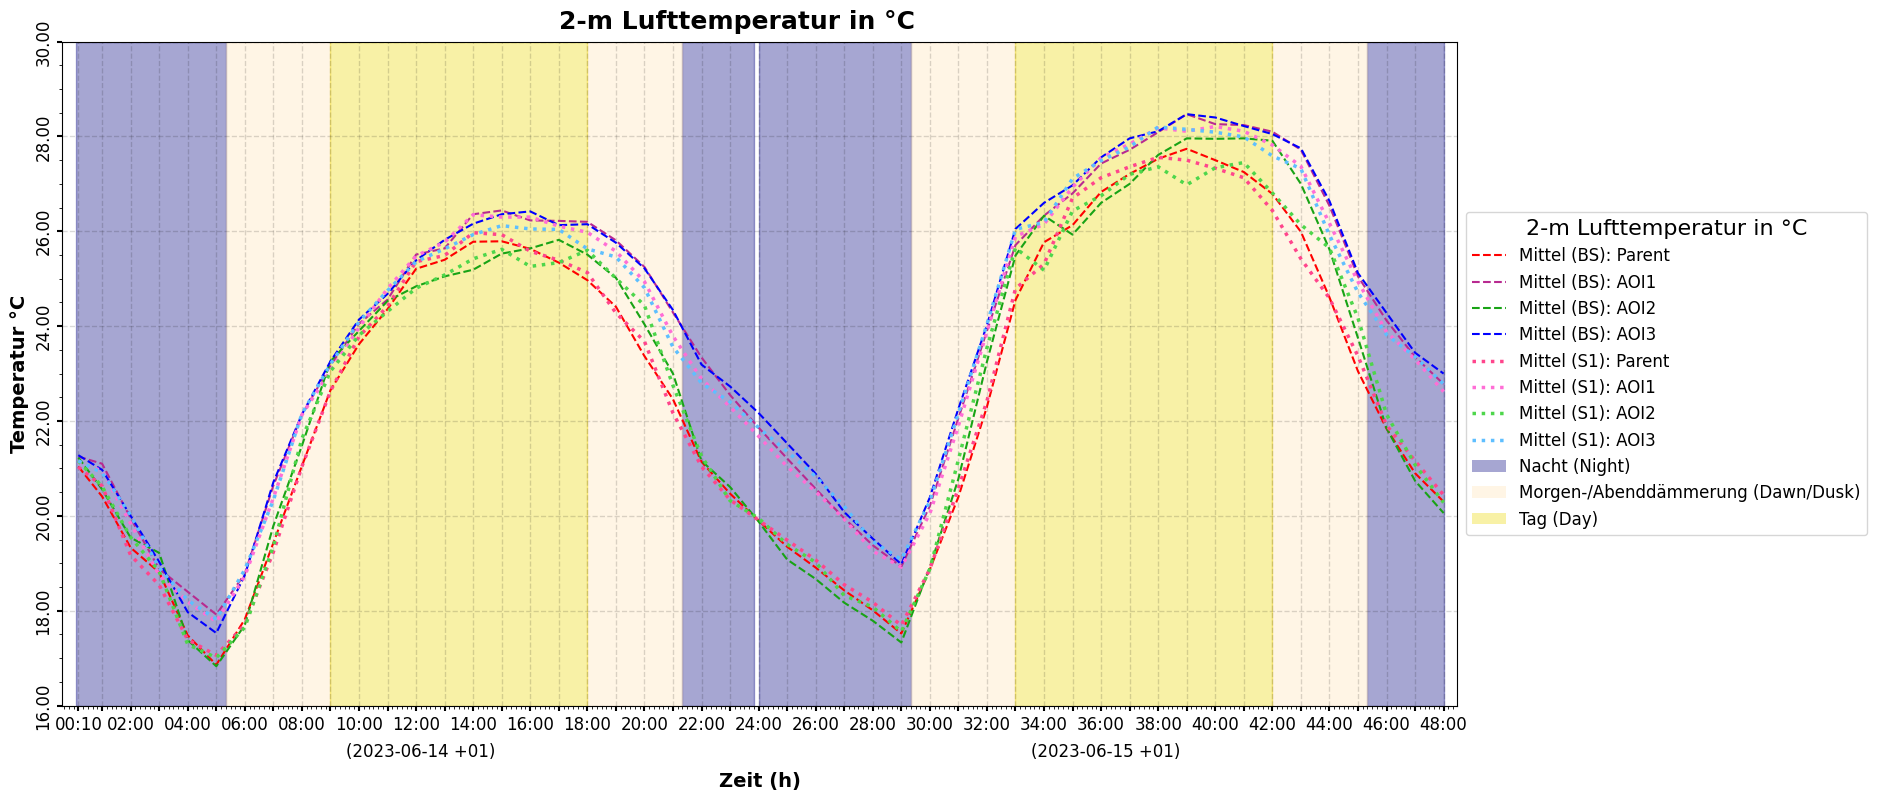

In [62]:
# Create a figure and an axes object for the plot.
fig, ax = plt.subplots(figsize=(18, 8), facecolor="w", edgecolor="k")

# Set the main title of the plot, including the variable description and unit.
plt.suptitle(f"2-m Lufttemperatur in {unit}", fontsize=18, weight="bold")
# Adjust subplot parameters for a tight layout, leaving space for title and legend.
plt.subplots_adjust(top=0.94)

# Configure major grid lines for better readability.
ax.grid(which="major", axis="both", linestyle="--", linewidth=1, color="#00000050", alpha=0.15)
# Enable minor ticks for more detailed axis marking.
ax.minorticks_on()
# Customize tick parameters for x and y axes (font size, rotation, line width).
ax.tick_params(axis="x", labelsize=12, rotation=0, width=1.5)
ax.tick_params(axis="y", labelsize=12, rotation=90, width=1.5)

# Format y-axis labels to two decimal places.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y_val, pos: f"{y_val:.2f}"))
# Set x-axis label.
ax.set_xlabel(f"Zeit (h)", fontsize=14, weight="bold")
# Adjust x-axis label position.
ax.xaxis.set_label_coords(0.5, -0.1)
# Set y-axis label, including the temperature unit.
ax.set_ylabel(f"Temperatur {unit}", fontsize=14, weight="bold")

# Set margins for the plot data area.
ax.margins(0.01)

# Set primary x-axis ticks using `time_sequence_hourly` indices for plotting.
# The corresponding labels are set using `time_equivalent_hourly`.
ax.xaxis.set_major_locator(ticker.FixedLocator(time_sequence_hourly))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(time_equivalent_hourly))

# Hide every other x-tick label to prevent overcrowding.
for i, label in enumerate(ax.get_xticklabels()):
    if i % 2 != 0:
        label.set_visible(False)

# Set a secondary x-axis to display date labels for the two days.
sec_xaxis_pos = 0.015 # Position of the secondary x-axis relative to the main axis.
sec = ax.secondary_xaxis(location=sec_xaxis_pos)
# Set specific ticks and labels for the dates.
# 72 time steps = 12 hours (72 * 10 min = 720 min = 12 hours).
# 144 time steps = 24 hours.
sec.set_xticks([72, 72 + 144], labels=["\n\n(2023-06-14 +01)", "\n\n(2023-06-15 +01)"])
# Customize secondary x-axis tick parameters.
sec.tick_params("x", length=0, labelsize=12)
sec.spines["bottom"].set_linewidth(0) # Hide the secondary x-axis spine.

# Set y-axis limits and major ticks.
ax.set_ylim([16, 30])
ax.set_yticks(np.arange(16, 31, 2))
# Center y-axis tick labels.
center_yticks(ax)

# Draw `axvspan` (vertical spans) to represent different sun cycle periods (Night, Dawn/Dusk, Day).
# These are calculated based on specific time equivalents from `time_sequence_all`.
# Night (Dark Blue): Before 05:20 and after 21:20 (for Day 1), and similar for Day 2.
ax.axvspan(-0.5, time_sequence_all[time_equivalent_all.index('05:20')], alpha=0.35, color='#000080')
ax.axvspan(time_sequence_all[time_equivalent_all.index('21:20')], time_sequence_all[time_equivalent_all.index('24:00') - 1], alpha=0.35, color='#000080') # 24:00 is end of Day 1

# Morning/Evening Twilight (Light Orange): 05:20 to 09:00, and 18:00 to 21:20 (for Day 1), and similar for Day 2.
ax.axvspan(time_sequence_all[time_equivalent_all.index('05:20')], time_sequence_all[time_equivalent_all.index('09:00')], alpha=0.35, color='#ffe4b5')
ax.axvspan(time_sequence_all[time_equivalent_all.index('18:00')], time_sequence_all[time_equivalent_all.index('21:20')], alpha=0.35, color='#ffe4b5')

# Day (Yellow): 09:00 to 18:00 (for Day 1), and similar for Day 2.
ax.axvspan(time_sequence_all[time_equivalent_all.index('09:00')], time_sequence_all[time_equivalent_all.index('18:00')], alpha=0.35, color='#ebd700')

# Extend sun cycle spans to the second day (assuming 144 steps = 24 hours).
# Day 2 Night (starting from time step 144 + index of 21:20)
ax.axvspan(time_sequence_all[time_equivalent_all.index('24:00')], time_sequence_all[time_equivalent_all.index('29:20')], alpha=0.35, color='#000080')
ax.axvspan(time_sequence_all[time_equivalent_all.index('45:20')], time_sequence_all[total_time_steps -1], alpha=0.35, color='#000080')

# Day 2 Twilight
ax.axvspan(time_sequence_all[time_equivalent_all.index('29:20')], time_sequence_all[time_equivalent_all.index('33:00')], alpha=0.35, color='#ffe4b5')
ax.axvspan(time_sequence_all[time_equivalent_all.index('42:00')], time_sequence_all[time_equivalent_all.index('45:20')], alpha=0.35, color='#ffe4b5')

# Day 2 Day
ax.axvspan(time_sequence_all[time_equivalent_all.index('33:00')], time_sequence_all[time_equivalent_all.index('42:00')], alpha=0.35, color='#ebd700')


# Plot mean temperature data for Baseline (dashed lines).
# `shift` is used to slightly offset lines if needed for clarity.
shift = 0 
(line1,) = ax.plot(df_0_plot["Time step"] - shift, df_0_plot[f"Mean (BS)"].astype(float),
                   label=f"Mittel (BS): Parent", color="#ff0000", linestyle="dashed", linewidth=1.5,)
(line2,) = ax.plot(df_1_plot["Time step"] - shift, df_1_plot[f"Mean (BS)"].astype(float),
                   label=f"Mittel (BS): AOI1", color="#b82a90", linestyle="dashed", linewidth=1.5,)
(line3,) = ax.plot(df_2_plot["Time step"] - shift, df_2_plot[f"Mean (BS)"].astype(float),
                   label=f"Mittel (BS): AOI2", color="#18a315", linestyle="dashed", linewidth=1.5,)
(line4,) = ax.plot(df_3_plot["Time step"] - shift, df_3_plot[f"Mean (BS)"].astype(float),
                   label=f"Mittel (BS): AOI3", color="#0000ff", linestyle="dashed", linewidth=1.5,)

# Plot mean temperature data for Scenario 1 (dotted lines).
(line5,) = ax.plot(df_0_plot["Time step"] - shift, df_0_plot[f"Mean (S1)"].astype(float),
                   label=f"Mittel (S1): Parent", color="#ff458c", linestyle=":", linewidth=2.5,)
(line6,) = ax.plot(df_1_plot["Time step"] - shift, df_1_plot[f"Mean (S1)"].astype(float),
                   label=f"Mittel (S1): AOI1", color="#ff6ed6", linestyle=":", linewidth=2.5,)
(line7,) = ax.plot(df_2_plot["Time step"] - shift, df_2_plot[f"Mean (S1)"].astype(float),
                   label=f"Mittel (S1): AOI2", color="#4ed64b", linestyle=":", linewidth=2.5,)
(line8,) = ax.plot(df_3_plot["Time step"] - shift, df_3_plot[f"Mean (S1)"].astype(float),
                   label=f"Mittel (S1): AOI3", color="#5ebfff", linestyle=":", linewidth=2.5,)

# Create custom legend handles for the sun cycle spans.
legend_handles = [
    Patch(facecolor='#000080', edgecolor='none', alpha=0.35, label='Nacht (Night)'),
    Patch(facecolor='#ffe4b5', edgecolor='none', alpha=0.35, label='Morgen-/Abenddämmerung (Dawn/Dusk)'),
    Patch(facecolor='#ebd700', edgecolor='none', alpha=0.35, label='Tag (Day)')
]

# Combine the automatically generated line handles/labels with custom sun cycle handles.
handles, labels = ax.get_legend_handles_labels()
handles.extend(legend_handles)

# Display the legend.
ax.legend(handles=handles, title=f"2-m Lufttemperatur in {unit}",
          title_fontsize=16,
          fontsize=12,
          loc="center left",
          bbox_to_anchor=(1, 0.5)) # Position the legend outside the plot area.
plt.show()

## 11. Summarize Statistical Results
This section defines the print_df_summary function, which computes and prints various statistics from an aggregated DataFrame. This includes overall and daily minimum/maximum mean temperatures for both Baseline and Scenario 1, as well as counts of time instances where the t-test results indicated "Reject null" or "Failed to reject null" hypotheses.

In [63]:
def print_df_summary(df):
    """
    Computes and prints a summary of statistics for mean temperatures and t-test results
    from a given DataFrame. This includes overall and daily min/max values for both
    simulation scenarios, and counts of t-test outcomes.

    Args:
        df (pandas.DataFrame): The DataFrame containing aggregated mean temperatures
                               and t-test results.
    """
    # --- Overall Statistics (Day 1 and Day 2 combined) ---
    # Find the index of the maximum and minimum mean values for Baseline (BS).
    max_idx_BS = df['Mean (BS)'].astype(float).idxmax() # Convert to float for accurate max/min
    min_idx_BS = df['Mean (BS)'].astype(float).idxmin()
    # Get the time (hr) corresponding to these max/min values.
    max_time_BS = df.loc[max_idx_BS, 'Time (hr)']
    min_time_BS = df.loc[min_idx_BS, 'Time (hr)']
    
    # Find the index of the maximum and minimum mean values for Scenario 1 (S1).
    max_idx_S1 = df['Mean (S1)'].astype(float).idxmax()
    min_idx_S1 = df['Mean (S1)'].astype(float).idxmin()
    # Get the time (hr) corresponding to these max/min values.
    max_time_S1 = df.loc[max_idx_S1, 'Time (hr)']
    min_time_S1 = df.loc[min_idx_S1, 'Time (hr)']

    print("Statistics of mean (Day 1 and Day 2 combined):")
    print("--Baseline--")
    print(f"Max: {max_time_BS} ({df['Mean (BS)'].astype(float).max():.2f})")
    print(f"Min: {min_time_BS} ({df['Mean (BS)'].astype(float).min():.2f})")
    print("--Scenario I--")
    print(f"Max: {max_time_S1} ({df['Mean (S1)'].astype(float).max():.2f})")
    print(f"Min: {min_time_S1} ({df['Mean (S1)'].astype(float).min():.2f})")

    print("\n--- Statistics of mean (Day 1) ---")
    # Day 1 covers the first 144 time steps (24 hours).
    df_day1 = df.head(144)
    max_idx_BS_day1 = df_day1['Mean (BS)'].astype(float).idxmax()
    min_idx_BS_day1 = df_day1['Mean (BS)'].astype(float).idxmin()
    max_time_BS_day1 = df_day1.loc[max_idx_BS_day1, 'Time (hr)']
    min_time_BS_day1 = df_day1.loc[min_idx_BS_day1, 'Time (hr)']
    
    max_idx_S1_day1 = df_day1['Mean (S1)'].astype(float).idxmax()
    min_idx_S1_day1 = df_day1['Mean (S1)'].astype(float).idxmin()
    max_time_S1_day1 = df_day1.loc[max_idx_S1_day1, 'Time (hr)']
    min_time_S1_day1 = df_day1.loc[min_idx_S1_day1, 'Time (hr)']

    print("--Baseline--")
    print(f"Max: {max_time_BS_day1} ({df_day1['Mean (BS)'].astype(float).max():.2f})")
    print(f"Min: {min_time_BS_day1} ({df_day1['Mean (BS)'].astype(float).min():.2f})")
    print("--Scenario I--")
    print(f"Max: {max_time_S1_day1} ({df_day1['Mean (S1)'].astype(float).max():.2f})")
    print(f"Min: {min_time_S1_day1} ({df_day1['Mean (S1)'].astype(float).min():.2f})")

    print("\n--- Statistics of mean (Day 2) ---")
    # Day 2 covers time steps from index 144 onwards.
    df_day2 = df.iloc[144:]
    max_idx_BS_day2 = df_day2['Mean (BS)'].astype(float).idxmax()
    min_idx_BS_day2 = df_day2['Mean (BS)'].astype(float).idxmin()
    max_time_BS_day2 = df_day2.loc[max_idx_BS_day2, 'Time (hr)']
    min_time_BS_day2 = df_day2.loc[min_idx_BS_day2, 'Time (hr)']
    
    max_idx_S1_day2 = df_day2['Mean (S1)'].astype(float).idxmax()
    min_idx_S1_day2 = df_day2['Mean (S1)'].astype(float).idxmin()
    max_time_S1_day2 = df_day2.loc[max_idx_S1_day2, 'Time (hr)']
    min_time_S1_day2 = df_day2.loc[min_idx_S1_day2, 'Time (hr)']

    print("--Baseline--")
    print(f"Max: {max_time_BS_day2} ({df_day2['Mean (BS)'].astype(float).max():.2f})")
    print(f"Min: {min_time_BS_day2} ({df_day2['Mean (BS)'].astype(float).min():.2f})")
    print("--Scenario I--")
    print(f"Max: {max_time_S1_day2} ({df_day2['Mean (S1)'].astype(float).max():.2f})")
    print(f"Min: {min_time_S1_day2} ({df_day2['Mean (S1)'].astype(float).min():.2f})")

    print("\n--- T-test Results Summary ---")
    # Create lists of "Time (hr)" values where t-test result is "Failed to reject null" or "Reject null".
    fail_to_reject_times = df.loc[df['t-test'] == 'Failed to reject null', 'Time (hr)'].tolist()
    reject_times = df.loc[df['t-test'] == 'Reject null', 'Time (hr)'].tolist()

    # Print the counts and lists of times for each t-test outcome.
    print(f"Time (hr) values where the t-test result is 'Failed to reject null' at {len(fail_to_reject_times)} instances.")
    # print(f"Times: {', '.join(fail_to_reject_times)}") # Uncomment to see the actual times
    print(f"Time (hr) values where the t-test result is 'Reject null' at {len(reject_times)} instances.")
    # print(f"Times: {', '.join(reject_times)}") # Uncomment to see the actual times

    print("\n--- Hypothesis Statements ---")
    print("NULL Hypothesis (H0): There is no significant difference in the mean between the two simulations (p-value >= alpha).")
    print("Alternative Hypothesis (H1): There is a significant difference in the mean between the two simulations (p-value < alpha).")

In [64]:
# Call the `print_df_summary` function to display the statistical summary for the overall domain (df_0).
print_df_summary(df_0)

Statistics of mean (Day 1 and Day 2 combined):
--Baseline--
Max: 38:10 (27.82)
Min: 05:00 (16.86)
--Scenario I--
Max: 39:50 (27.82)
Min: 05:10 (17.04)

--- Statistics of mean (Day 1) ---
--Baseline--
Max: 15:10 (25.80)
Min: 05:00 (16.86)
--Scenario I--
Max: 13:50 (26.01)
Min: 05:10 (17.04)

--- Statistics of mean (Day 2) ---
--Baseline--
Max: 38:10 (27.82)
Min: 28:40 (17.51)
--Scenario I--
Max: 39:50 (27.82)
Min: 29:00 (17.69)

--- T-test Results Summary ---
Time (hr) values where the t-test result is 'Failed to reject null' at 24 instances.
Time (hr) values where the t-test result is 'Reject null' at 264 instances.

--- Hypothesis Statements ---
NULL Hypothesis (H0): There is no significant difference in the mean between the two simulations (p-value >= alpha).
Alternative Hypothesis (H1): There is a significant difference in the mean between the two simulations (p-value < alpha).


In [65]:
# This code block is commented out, but if uncommented, it would save `df_2` (AOI2 - Marktstätte)
# to a CSV file. This can be useful for external analysis or sharing.
# df_2.to_csv(f"./_other/markstaette_simulation_230614_agg{aggregate_time_steps}.csv", )